In [ ]:
!pip install fasttext

In [ ]:
!pip install tensorflowjs

In [ ]:
!pip install tensorflow

In [ ]:
import fasttext
import fasttext.util
import nltk
import json
import re
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import random
from nltk.tokenize import word_tokenize
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

#**Preprocessing Text**

In [ ]:
replacement_text = [
    ['saya',['gua', 'gue', 'aku', 'gueh', 'ogut', 'gw', 'beta', 'gweh']],
    ['kamu', ['lu', 'sampean', 'elu', 'ngana', 'ente', 'anda']],
    ['hak asasi manusia', ['ham']],
    ['pencuri', ['maling']]
]

In [ ]:
def preprocessing_text(sentences):
    filtered_words = re.sub(r'[^\w\d\s]', '', sentences.lower())
    tokenized_words = word_tokenize(filtered_words)
    cleaned_word = []

    for word in tokenized_words:
        replaced = False

        for replacement, targets in replacement_text:
            if word in targets:
                cleaned_word.append(replacement)
                replaced = True
        if not replaced:
            cleaned_word.append(word)

    return ' '.join(cleaned_word)

#**Import Train & Val Data**

In [ ]:
# Load the dataset
with open('/content/law_qna.json', 'r', encoding='utf-8') as content:
    chatbot = json.load(content)

data = pd.DataFrame(chatbot['intents'])

**Law Q&A**

In [ ]:
# Create dictionary for patterns and responses
dictionary = {"tag": [], "patterns": [], "responses": []}

for i in range(len(data)):
    pattern = data[data.index == i]['patterns'].values[0]
    response = data[data.index == i]['responses'].values[0]
    tag = data[data.index == i]['tag'].values[0]
    for j in range(len(pattern)):
        dictionary['tag'].append(tag)
        dictionary['patterns'].append(preprocessing_text(pattern[j]))
        dictionary['responses'].append(response)

data = pd.DataFrame.from_dict(dictionary)
data

,tag,patterns,responses
0,greetings,hai,"[Halo, ada yang bisa kami bantu?, Selamat data..."
1,greetings,halo,"[Halo, ada yang bisa kami bantu?, Selamat data..."
2,greetings,hi,"[Halo, ada yang bisa kami bantu?, Selamat data..."
3,greetings,assalamualaikum,"[Halo, ada yang bisa kami bantu?, Selamat data..."
4,greetings,helo,"[Halo, ada yang bisa kami bantu?, Selamat data..."
...,...,...,...
516,56_pencurian_ringan_kuhp,bagaimana kuhp mengatur pencurian ringan atau ...,[Pencurian ringan adalah pencurian yang dilaku...
517,56_pencurian_ringan_kuhp,jelaskan mengenai pencurian ringan atau curing,[Pencurian ringan adalah pencurian yang dilaku...
518,56_pencurian_ringan_kuhp,apa yang dimaksud dengan pencurian ringan atau...,[Pencurian ringan adalah pencurian yang dilaku...
519,56_pencurian_ringan_kuhp,apa itu pencurian ringan atau curing,[Pencurian ringan adalah pencurian yang dilaku...


**Q&A Validation**

In [ ]:
with open('/content/law_qna_val_2.json', 'r', encoding='utf-8') as content:
    val_chatbot = json.load(content)
val_data = pd.DataFrame(val_chatbot['intents'])

In [ ]:
# Create dictionary for validation patterns
dictionary = {"tag": [], "patterns": []}

for i in range(len(val_data)):
    pattern = val_data[val_data.index == i]['patterns'].values[0]
    tag = val_data[val_data.index == i]['tag'].values[0]
    for j in range(len(pattern)):
        dictionary['tag'].append(tag)
        dictionary['patterns'].append(preprocessing_text(pattern[j]))

val_data = pd.DataFrame.from_dict(dictionary)
val_data

,tag,patterns
0,greetings,hai
1,greetings,haloo
2,greetings,halo selamat pagi
3,morning,pagii
4,morning,selamat pagi
...,...,...
214,55_pencurian_kekerasan_kuhp,pencurian dengan kekerasan atau curas adalah
215,55_pencurian_kekerasan_kuhp,bagaimana kuhp mengatur pencurian dengan keker...
216,55_pencurian_kekerasan_kuhp,gimana bisa kasus pencurian tergolong ke dalam...
217,56_pencurian_ringan_kuhp,pencurian ringan atau curing adalah


In [ ]:
# Training
data['tag'].unique()

array(['greetings', 'morning', 'afternoon', 'evening', 'night', 'goodbye',
       'thanks', 'about_chatbot', 'skill_chatbot', 'creation', 'casual',
       'ask_question', 'help', 'no_need_help', 'wrong', 'location',
       'done', '1_tujuan_kuhp', '2_pengertian_kuhp',
       '3_lingkup_waktu_kuhp', '4_asas_wilayah_kuhp', '5_pasal-2_kuhp',
       '6_revisi_uu_setelah_kejahatan_dilakukan',
       '7_asas_perlindungan_nasional_pasif', '8_asas_nasional_aktif',
       '9_definisi_tindak_pidana', '10_pemufakatan_jahat',
       '11_persiapan_tindak_pidana', '12_percobaan_tindak_pidana',
       '13_pelaku_tindak_pidana', '14_pembantuan_tindak_pidana',
       '15_pengulangan_tindak_pidana', '16_jenis_sanksi_kuhp',
       '17_perubahan_peraturan_yang_menguntungkan_pelaku',
       '18_pasal-5_kuhp', '19_pasal-17_kuhp', '20_kasus_pidana_umum',
       '21_terorisme_kuhp', '22_tindak_pidana_terhadap_anak',
       '23_tindak_pidana_lingkungan_hidup', '24_ham_kuhp',
       '25_hak_tersangka_terdakwa_k

In [ ]:
# Total train tag
print('Total train tag: ', len(data['tag'].unique()))

Total train tag:  73


In [ ]:
# Validation
val_data['tag'].unique()

array(['greetings', 'morning', 'afternoon', 'evening', 'night', 'goodbye',
       'thanks', 'about_chatbot', 'skill_chatbot', 'creation', 'casual',
       'ask_question', 'help', 'no_need_help', 'wrong', 'location',
       'done', '1_tujuan_kuhp', '2_pengertian_kuhp',
       '3_lingkup_waktu_kuhp', '4_asas_wilayah_kuhp', '5_pasal-2_kuhp',
       '6_revisi_uu_setelah_kejahatan_dilakukan',
       '7_asas_perlindungan_nasional_pasif', '8_asas_nasional_aktif',
       '9_definisi_tindak_pidana', '10_pemufakatan_jahat',
       '11_persiapan_tindak_pidana', '12_percobaan_tindak_pidana',
       '13_pelaku_tindak_pidana', '14_pembantuan_tindak_pidana',
       '15_pengulangan_tindak_pidana', '16_jenis_sanksi_kuhp',
       '17_perubahan_peraturan_yang_menguntungkan_pelaku',
       '18_pasal-5_kuhp', '19_pasal-17_kuhp', '20_kasus_pidana_umum',
       '21_terorisme_kuhp', '22_tindak_pidana_terhadap_anak',
       '23_tindak_pidana_lingkungan_hidup', '24_ham_kuhp',
       '25_hak_tersangka_terdakwa_k

In [ ]:
# Total val tag
print('Total val tag: ', len(val_data['tag'].unique()))

Total val tag:  73


**Add Word Dictionary**

In [ ]:
with open('/content/dictionaries.json', 'r') as f:
  json_dict = json.load(f)

In [ ]:
# Tokenizer and padding sequences
tokenizer_json = json_dict.keys()
tokenizer = Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(tokenizer_json)

word_index = tokenizer.word_index
print(len(word_index))

18727


In [ ]:
# Shuffle data
data = shuffle(data)
val_data = shuffle(val_data)

In [ ]:
# Encode labels
label_encode = LabelEncoder()

tokenizer.fit_on_texts(data['patterns'])
tokenizer.fit_on_texts(val_data['patterns'])

In [ ]:
# Convert patterns to sequences
pattern_train = tokenizer.texts_to_sequences(data['patterns'])
x_train = pad_sequences(pattern_train, padding='post', maxlen=12, truncating='pre')

print("Training Input Shape : ", x_train.shape)
print(len(x_train[0]))

# Training tag as label
x_label = label_encode.fit_transform(data['tag'])
print("Training Label Shape : ", x_label.shape)
print("Num of classes: ", len(np.unique(x_label)))

Training Input Shape :  (521, 12)
12
Training Label Shape :  (521,)
Num of classes:  73


In [ ]:
pattern_val = tokenizer.texts_to_sequences(val_data['patterns'])
y_train = pad_sequences(pattern_val, padding='post', maxlen=12, truncating='pre')

print("Validation Input Shape : ", y_train.shape)
print(len(y_train[0]))

y_label = label_encode.fit_transform(val_data['tag'])
print("Validation Label Shape : ",y_label.shape)
print("Num of classes: ", len(np.unique(y_label)))

Validation Input Shape :  (219, 12)
12
Validation Label Shape :  (219,)
Num of classes:  73


In [ ]:
vocabulary = len(tokenizer.word_index)

print("Number unique word : ", vocabulary)
print("Output Length : ", label_encode.classes_.shape[0])

Number unique word :  18808
Output Length :  73


In [ ]:
word_dictionary = {item[0]: item[1] for item in tokenizer.word_index.items()}

with open('tokenizer_chatbot_dict.json', 'w') as json_file:
  json.dump(word_dictionary, json_file, indent=4)

**Convert Text into JSON**

In [ ]:
leDecode = LabelEncoder()
leDecode.fit(val_data['tag'])
name_mapping = dict(zip(leDecode.classes_, leDecode.transform(leDecode.classes_)))
transformed = leDecode.transform(leDecode.classes_).tolist()
name_mapping = dict(zip(leDecode.classes_, transformed))

with open('label_decoder.json', 'w') as json_file:
  json.dump(name_mapping, json_file, indent=4)

# **FastText**

In [ ]:
# Load pre-trained FastText embeddings
fasttext.util.download_model('id', if_exists='ignore')  # Download the Indonesian model

'cc.id.300.bin'

In [ ]:
ft = fasttext.load_model('/content/cc.id.300.bin')  # Load the model

In [ ]:
max = vocabulary + 1
word_index = tokenizer.word_index

embedding_matrix = np.zeros((max, 300)).astype(object)

for word, i in word_index.items():
  embedding_vector = ft.get_word_vector(word)
  if embedding_vector is not None:
     embedding_matrix[i] = embedding_vector

In [ ]:
# Model building and training
model = tf.keras.Sequential([
      tf.keras.layers.Input(shape=(x_train.shape[1],)),
      tf.keras.layers.Embedding(input_dim=vocabulary+1, output_dim = 300, mask_zero=True, weights=[embedding_matrix], trainable=False),
      tf.keras.layers.Dropout(0.2),

      tf.keras.layers.GRU(128, return_sequences=True, reset_after=False),
      tf.keras.layers.LayerNormalization(),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.GRU(128, return_sequences=False, reset_after=False),
      tf.keras.layers.LayerNormalization(),
      tf.keras.layers.Dropout(0.2),


      tf.keras.layers.Dense(256, activation='relu'),
      tf.keras.layers.LayerNormalization(),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.LayerNormalization(),
      tf.keras.layers.Dense(len(np.unique(x_label)), activation='softmax')
])


model.summary()
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 12, 300)             │       5,642,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 12, 300)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 12, 128)             │         164,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization                  │ (None, 12, 128)             │             256 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 12, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 128)                 │          98,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_1                │ (None, 128)                 │             256 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_2                │ (None, 256)                 │             512 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_3                │ (None, 128)                 │             256 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 73)                  │           9,417 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,982,741 (22.82 MB)

 Trainable params: 340,041 (1.30 MB)

 Non-trainable params: 5,642,700 (21.53 MB)

In [ ]:
# Callback for early stopping
class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') > 0.9 and logs.get('val_accuracy') > 0.83:
            self.model.stop_training = True

In [ ]:
# Training the model
history = model.fit(x_train, x_label, validation_data=(y_train, y_label), batch_size=32, epochs=50, callbacks=[MyCallback()])

Epoch 1/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step - accuracy: 0.0272 - loss: 4.6666 - val_accuracy: 0.1735 - val_loss: 3.7720
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.1156 - loss: 3.9067 - val_accuracy: 0.3059 - val_loss: 2.8817
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.3030 - loss: 3.1054 - val_accuracy: 0.4886 - val_loss: 2.2392
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.4183 - loss: 2.5711 - val_accuracy: 0.6164 - val_loss: 1.8238
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.4893 - loss: 2.2400 - val_accuracy: 0.6575 - val_loss: 1.4928
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.5653 - loss: 1.8325 - val_accuracy: 0.7169 - val_loss: 1.2395
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.7045 - loss: 1.4071 - val_accuracy: 0.7306 - val_loss: 1.0957
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - accuracy: 0.7201 - loss: 1.2462 - val_accuracy: 0.7717 

In [ ]:
# Plotting training history
def plot_training_history(history):
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='green')
    plt.legend(loc='lower right')
    plt.title('Accuracy')
    plt.ylim(0, 1.0)

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss', color='orange')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='yellow')
    plt.legend(loc='upper right')
    plt.title('Loss')
    plt.ylim(0, 4.0)

    plt.show()

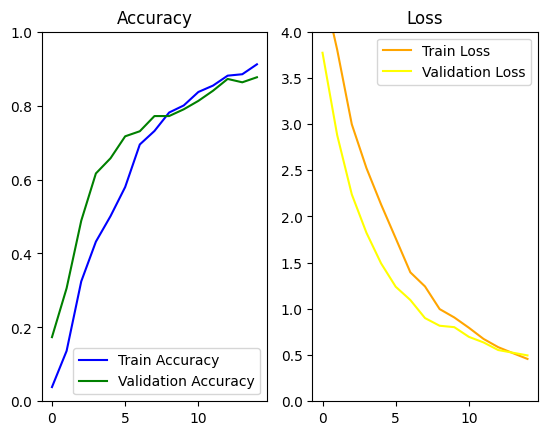

In [ ]:
plot_training_history(history)

In [ ]:
# Function to test the chatbot
def chatbot_test():
    while True:
      user_input = input("User: ").lower()
      pattern_test=preprocessing_text(user_input)
      pattern_test = tokenizer.texts_to_sequences([pattern_test])
      x_test = pad_sequences(pattern_test, x_train.shape[1])

      prediction = model.predict(x_test)[0]

      # Confidence Score
      max_prob = np.max(prediction)

      if max_prob < 0.5:
          label = "unknown"
          response = ["Maaf, saya tidak mengerti. Bisakah kamu menjelaskan kembali?"]
      else:
          label = label_encode.inverse_transform([np.argmax(prediction)])[0]
          response = data[data['tag'] == label]['responses'].values[0]

      print(f"Label: {label}")
      print(f"Confidence: {max_prob:.2f}")
      print("LegalGenie: ", format(random.choice(response)))

      if label=='goodbye' or label=='thanks' or label=='done':
        break

In [ ]:
chatbot_test()

User: haloo
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step
Label: greetings
Confidence: 0.73
LegalGenie:  Selamat datang, apa yang membawamu ke sini?
User: saya mau nanya tentang hukuman mencuri
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Label: 51_pidana_pencurian_kuhp
Confidence: 0.91
LegalGenie:  Tindak pidana pencurian dalam KUHP baru UU No. 1 tahun 2023 diatur dalam Pasal 476 sampai 481, yaitu:
1. Pencurian Biasa (Cubis):
- Pasal 476: Mengatur mengenai pencurian biasa dengan pidana penjara paling lama 5 tahun atau pidana denda paling banyak kategori V.
2. Pencurian Dengan Pemberatan (Curat):
- Pasal 477: Mengatur mengenai pencurian dengan pemberatan dengan pidana penjara paling lama 7 tahun atau pidana denda paling banyak kategori V. Jika disertai cara-cara tertentu seperti kekerasan atau terjadi dalam situasi khusus (misalnya saat bencana alam), pidana bisa lebih berat.
3. Pencurian Ringan (Curing):
- Pasal 478: Mengatur jika tindak pidana sebagaimana dimaksud dalam Pasal 476 dan Pasal 477 aya

In [ ]:
import tensorflowjs as tfjs

In [ ]:
tfjs.converters.save_keras_model(model,'sample_data/models')
!zip -r models.zip sample_data/models/

failed to lookup keras version from the file,
    this is likely a weight only file
  adding: sample_data/models/ (stored 0%)
  adding: sample_data/models/group1-shard5of6.bin (deflated 7%)
  adding: sample_data/models/group1-shard4of6.bin (deflated 7%)
  adding: sample_data/models/group1-shard1of6.bin (deflated 7%)
  adding: sample_data/models/model.json (deflated 87%)
  adding: sample_data/models/group1-shard3of6.bin (deflated 7%)
  adding: sample_data/models/group1-shard6of6.bin (deflated 7%)
  adding: sample_data/models/group1-shard2of6.bin (deflated 7%)


In [ ]:
model.save('chatbot_model.h5')

In [ ]:
from google.colab import files
files.download('models.zip')
files.download('/content/chatbot_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>